**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

*Edición 2021*

----

# Trabajo práctico entregable - Parte 1

En esta notebook, vamos a cargar el conjunto de datos de [la compentencia Kaggle](https://www.kaggle.com/dansbecker/melbourne-housing-snapshot) sobre estimación de precios de ventas de propiedades en Melbourne, Australia.

Utilizaremos el conjunto de datos reducido producido por [DanB](https://www.kaggle.com/dansbecker). Hemos subido una copia a un servidor de la Universidad Nacional de Córdoba para facilitar su acceso remoto.

### Importación de librerías

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import missingno as msno

import seaborn as sns
sns.set_context('talk')

pd.set_option('display.max_columns', None)

In [2]:
import plotly
plotly.__version__
# Make sure it's 4.14.3

'5.2.2'

In [3]:
# To update plotly, uncomment and run the following line:
# !pip install plotly --upgrade

In [4]:
melb_df = pd.read_csv('datasets/melb_data.csv')
melb_df[:3]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0


---

## Ejercicio 1: 

1. Eliminar los valores extremos que no sean relevantes para la predicción de valores de las propiedades.

2. Investigar la distribución de las variables del conjunto de datos y seleccionar un subconjunto de columnas que les parezcan relevantes al problema de predicción del valor de la propiedad.
    1. Justificar cada columna no seleccionada.
    2. Para las variables categóricas seleccionadas, agrupe o combine las categorías poco frecuentes para asegurar que todos los grupos tengan un número mínimo de registros.

3. Agregar información adicional respectiva al entorno de una propiedad a partir del [conjunto de datos de AirBnB](https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv) utilizado en el práctico. 
    1. Seleccionar qué variables agregar y qué combinaciones aplicar a cada una. Por ejemplo, pueden utilizar solo la columna `price`, o aplicar múltiples transformaciones como la mediana o el mínimo.
    2. Utilizar la variable zipcode para unir los conjuntos de datos. Sólo incluir los zipcodes que tengan una cantidad mínima de registros (a elección) como para que la información agregada sea relevante.
    3. Investigar al menos otras 2 variables que puedan servir para combinar los datos, y justificar si serían adecuadas o no. Pueden asumir que cuentan con la ayuda de anotadores expertos para encontrar equivalencias entre barrios o direcciones, o que cuentan con algoritmos para encontrar las n ubicaciones más cercanas a una propiedad a partir de sus coordenadas geográficas. **NO** es necesario que realicen la implementación.

Pueden leer otras columnas del conjunto de AirBnB además de las que están en `interesting_cols`, si les parecen relevantes.


In [5]:
# data source:
# https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv
interesting_cols = [
  'description', 'neighborhood_overview',
  'street', 'neighborhood', 'city', 'suburb', 'state', 'zipcode',
  'price', 'weekly_price', 'monthly_price',
  'latitude', 'longitude',
]
airbnb_df = pd.read_csv(
    'datasets/cleansed_listings_dec18.csv',
    usecols=interesting_cols,low_memory=False)

In [6]:
airbnb_df[:3]

,description,neighborhood_overview,street,neighborhood,city,suburb,state,zipcode,latitude,longitude,price,weekly_price,monthly_price
0,"House: Clean, New, Modern, Quite, Safe. 10Km f...",Very safe! Family oriented. Older age group.,"Bulleen, VIC, Australia",Balwyn North,Manningham,Bulleen,VIC,3105,-37.772684,145.092133,60,NaN,NaN
1,A large air conditioned room with queen spring...,This hip area is a crossroads between two grea...,"Brunswick East, VIC, Australia",Brunswick,Moreland,Brunswick East,VIC,3057,-37.766505,144.980736,35,200.0,803.0
2,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,A stay at our apartment means you can enjoy so...,"St Kilda, VIC, Australia",St Kilda,Port Phillip,St Kilda,VIC,3182,-37.859755,144.977369,159,1253.0,4452.0


### Análisis del Datasets y Tipos de Datos

Como primer paso, daremos un vistazo general a los tipos de datos dentro del dataset **melb_df**

In [7]:
melb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

Antes de comenzar, vemos que la columna **Date** está como un String, por lo que la haremos una nueva variable Date transformandola en formato de fecha para lograr un mejor análisis sobre los datos.

In [8]:
melb_df['Date'] = pd.to_datetime(melb_df.Date)
print('Cantidad de fechas distintas:', melb_df['Date'].nunique())
melb_df['Date'].head()

Cantidad de fechas distintas: 58


0   2016-03-12
1   2016-04-02
2   2017-04-03
3   2017-04-03
4   2016-04-06
Name: Date, dtype: datetime64[ns]

In [9]:
print('Fecha desde:',melb_df['Date'].min())
print('Fecha Hasta:',melb_df['Date'].max())

Fecha desde: 2016-01-28 00:00:00
Fecha Hasta: 2017-12-08 00:00:00


Analizamos el código postal (**Postcode**)

In [10]:
print('Cantidad de valores nulos:',melb_df.Postcode.isna().sum())

Cantidad de valores nulos: 0


In [11]:
melb_df.Postcode.dtype

dtype('float64')

In [12]:
melb_df.Postcode.unique()

array([3067., 3042., 3206., 3078., 3018., 3025., 3143., 3032., 3147.,
       3034., 3183., 3103., 3104., 3204., 3165., 3128., 3019., 3186.,
       3187., 3056., 3055., 3105., 3125., 3124., 3126., 3054., 3163.,
       3162., 3161., 3148., 3068., 3058., 3066., 3108., 3084., 3185.,
       3184., 3040., 3041., 3065., 3031., 3011., 3146., 3046., 3043.,
       3188., 3122., 3081., 3166., 3079., 3021., 3033., 3101., 3102.,
       3144., 3012., 3145., 3000., 3127., 3039., 3189., 3015., 3051.,
       3070., 3167., 3052., 3044., 3207., 3181., 3072., 3073., 3121.,
       3205., 3141., 3006., 3182., 3020., 3107., 3071., 3142., 3087.,
       3003., 3016., 3085., 3013., 3057., 3061., 3053., 3002., 3060.,
       3123., 3047., 3083., 3008., 3153., 3193., 3806., 3155., 3088.,
       3023., 3151., 3192., 3064., 3977., 3136., 3175., 3089., 3172.,
       3109., 3111., 3754., 3095., 3076., 3131., 3199., 3200., 3437.,
       3803., 3777., 3190., 3037., 3038., 3173., 3075., 3093., 3337.,
       3082., 3132.,

Como el código postal no es una variable cuantitativa, por lo que para asegurar que sea categórica/cualitativa, la transformamos en tipo de datos String

In [13]:
melb_df.Postcode = melb_df.Postcode.astype(str)
melb_df.Postcode = melb_df.Postcode.str[0:4]
melb_df.Postcode.dtype

dtype('O')

In [14]:
melb_df.Postcode.value_counts()

3073    359
3020    306
3121    292
3040    290
3046    284
       ... 
3757      1
3438      1
3809      1
3775      1
3115      1
Name: Postcode, Length: 198, dtype: int64

In [15]:
print('Códigos postales desde:', min(melb_df.Postcode.values))
print('Códigos postales desde:', max(melb_df.Postcode.values))

Códigos postales desde: 3000
Códigos postales desde: 3977


Observaremos la falta de datos o los valores nulos dentro de la tabla, lo cual implican que debamos decidir que acciones se deben tomar para estos casos. 

In [16]:
melb_df.isna().sum()

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                62
Landsize            0
BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

De igual manera, realizamos la búsqueda de los valores en 0 dentro del dataset, para analizar la relevancia de la información presentada.

In [17]:
cols = melb_df[melb_df == 0].count(axis=0)
cols[cols > 0]

Distance           6
Bedroom2          16
Bathroom          34
Car             1026
Landsize        1939
BuildingArea      17
dtype: int64

*  Como punto importante, observamos que dirección, precio (price) y suburbio no tienen valores nulos, lo cual es beneficioso para el análisis de esta consigna.
* Podemos observar las columnas que poseen valores en 0, las cuales pueden considerarse para un futuro descarte, ya que no aportan información significativa para el análisis para esta consigna. La decisión de descartarlos o mantenerlos, se decidirá mientras se avance con el desarrollo para no producir desvión o introducir sesgos que no correspondan. 

---

### Actividad 1

**CONSIGNA**

> Eliminar los valores extremos que no sean relevantes para la predicción de valores de las propiedades.

Decribiremos a la columna **Price** (Precio) para ver las características de la misma.

In [18]:
melb_df[['Price']].describe().round(2)

,Price
count,13580.00
mean,1075684.08
std,639310.72
min,85000.00
25%,650000.00
50%,903000.00
75%,1330000.00
max,9000000.00


In [19]:
print('Mediana:',melb_df[['Price']].median())

Mediana: Price    903000.0
dtype: float64


Observamos que se registraron 13.580 propiedades en dicho dataset, con un precio de valor medio de 1.075.684 USD, una propiedad con un precio mínimo de 85.000 USD y una propiedad con precio máximo de 9M USD.

Las conclusiones rápidas que podemos notar son: Con una media de 1.075.684 USD y un máximo y mínimo ya dichos, claramente hay outliers en valores altos, ya que en su mayoría, la concentración de valores se da en el **cuartil 3**. Esto se da ya que **la media es mayor a la mediana**. 

Demostraremos en una visualización de caja o boxenplot, lo concluido en el paso anterior: 

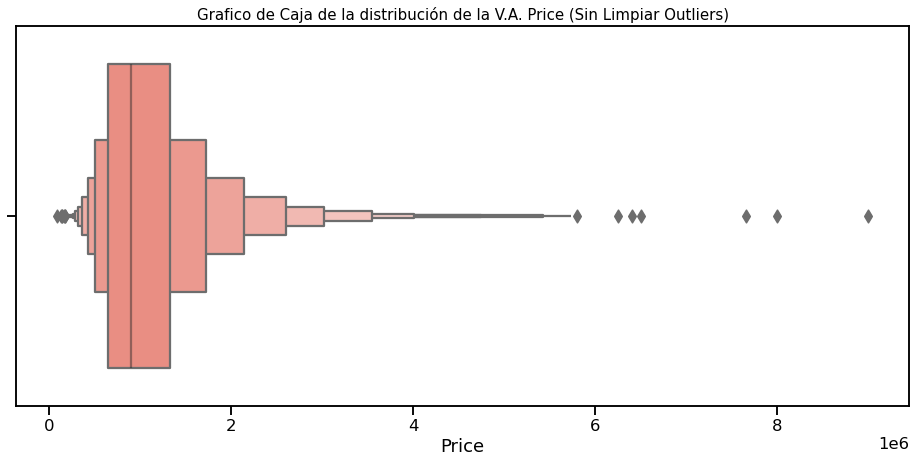

In [20]:
plt.figure(figsize=(16, 7))
sns.boxenplot(data=melb_df, x="Price", color='salmon')
plt.title("Grafico de Caja de la distribución de la V.A. Price (Sin Limpiar Outliers)", fontsize=15)
plt.show()

El el gráfico, visualizamos que la variable presenta valores menos concentrados en cuanto más altos estos se hacen, y se puede intuir, que por encima de 4M USD, estos se hacen más atípicos.

Para analizar esta hipótesis, visualizaremos las propiedades que superan el monto de 4M USD para comparar las caracteristicas con las que cuentan.

In [21]:
melb_df[melb_df['Price'] >= 4000000].head(70)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
108,Albert Park,115 Page St,4,h,4735000.0,S,Marshall,2017-02-25,3.3,3206,4.0,2.0,1.0,330.0,207.0,1910.0,Port Phillip,-37.84770,144.95580,Southern Metropolitan,3280.0
251,Armadale,367 Dandenong Rd,6,h,5525000.0,S,Marshall,2016-09-17,6.3,3143,5.0,3.0,4.0,1491.0,516.0,1935.0,Stonnington,-37.86020,145.01300,Southern Metropolitan,4836.0
273,Armadale,44 Hampden Rd,4,h,4200000.0,VB,Kay,2016-11-27,6.3,3143,4.0,3.0,3.0,563.0,333.0,2000.0,Stonnington,-37.85820,145.01380,Southern Metropolitan,4836.0
515,Balwyn,349 Union Rd,6,h,4000000.0,VB,Jellis,2016-03-12,9.7,3103,6.0,4.0,7.0,2051.0,449.0,1935.0,Boroondara,-37.80510,145.10160,Southern Metropolitan,5682.0
573,Balwyn,8 Raynes St,5,h,4000000.0,VB,RT,2016-11-27,9.7,3103,5.0,4.0,3.0,1437.0,NaN,NaN,Boroondara,-37.80580,145.08820,Southern Metropolitan,5682.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12253,Camberwell,78 Bowen St,4,h,4060000.0,S,Kay,2017-03-09,7.7,3124,4.0,3.0,2.0,947.0,NaN,NaN,NaN,-37.84457,145.06218,Southern Metropolitan,8920.0
12557,Middle Park,136 Page St,5,h,6400000.0,S,Marshall,2017-09-09,3.0,3206,5.0,2.0,1.0,553.0,308.0,1920.0,NaN,-37.84908,144.95753,Southern Metropolitan,2019.0
12762,Kew,130 Sackville St,5,h,5065000.0,PI,RT,2017-09-16,5.4,3101,5.0,4.0,2.0,892.0,NaN,1917.0,NaN,-37.81420,145.05973,Southern Metropolitan,10331.0
13013,Kew,37 Wellington St,4,h,4000000.0,S,Marshall,2017-08-19,5.4,3101,4.0,2.0,3.0,792.0,NaN,NaN,NaN,-37.80926,145.03310,Southern Metropolitan,10331.0


In [22]:
melb_df[melb_df['Price'] >= 4000000].describe()

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,63.000000,6.300000e+01,63.000000,63.000000,63.000000,63.000000,63.000000,40.000000,43.000000,63.000000,63.000000,63.000000
mean,4.317460,4.848484e+06,6.526984,4.285714,3.079365,2.603175,836.111111,322.457500,1938.348837,-37.841831,145.027035,7831.507937
std,0.912731,1.002989e+06,3.073361,0.887704,1.036458,1.225267,376.524519,107.875155,44.414650,0.032216,0.039478,3209.607397
min,2.000000,4.000000e+06,1.500000,2.000000,1.000000,0.000000,220.000000,60.000000,1863.000000,-37.931680,144.955800,2019.000000
25%,4.000000,4.150000e+06,4.600000,4.000000,2.000000,2.000000,606.000000,274.250000,1910.000000,-37.858200,144.998040,4836.000000
50%,4.000000,4.525000e+06,5.600000,4.000000,3.000000,2.000000,787.000000,329.500000,1930.000000,-37.843100,145.026700,7217.000000
75%,5.000000,5.100000e+06,7.800000,5.000000,4.000000,3.000000,933.500000,375.000000,1975.500000,-37.816700,145.055800,10455.000000
max,7.000000,9.000000e+06,18.800000,7.000000,6.000000,7.000000,2079.000000,518.000000,2013.000000,-37.776300,145.161260,14887.000000


Observamos que las propiedades por encima de 4M tienen características que podrían justificar el precio de la propiedades, como por ejemplo la cantidad de habitaciones, o el área en donde se encuentra, como así también el área construida.

Luego de este análisis, optamos por sacar los outliers superiores por el método que utilizan los diagramas de cajas para este análisis.
El método consta de  2 partes:
1. Sacar el rango intercuartil: Q3 - Q1
2. Obtener los bigotes, tanto superior como inferior. Para el inferior se le resta al Q1 el rango intercuartil por 1.5, y para el superior es el Q3 más el rango intercuartil  multiplicado por 1.5.

El valor 1.5 es un valor dado para valores atípicos leves, pero pueden utilizarse valores superiores si es de preferencia.

Adjuntamos   [link de Wikipedia](https://es.wikipedia.org/wiki/Valor_at%C3%ADpico#:~:text=%2C%20o%20rango%20intercuart%C3%ADlico.,esa%20distancia%20(at%C3%ADpico%20extremo). en donde se puede obtener más detalle sobre el método utilizado.



In [23]:
def range_interquantile(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    # RI = Rango_Intercuartil
    RI = Q3 - Q1
    # BI = Bigote Inferior
    BI = Q1 - 1.5 * RI
    # BS = Bigote Superior
    BS = Q3 + 1.5 * RI
    return RI, BI, BS

In [24]:
RI, BI, BS = range_interquantile(melb_df, 'Price')

print('Rango Intercuartil:',RI)
print('Bigote Inferior:', BI)
print('Bigote Superior:',BS)

Rango Intercuartil: 680000.0
Bigote Inferior: -370000.0
Bigote Superior: 2350000.0


Aquí obtuvimos 3 valores, nuestro rango intercuartil (Q3-Q1), el bigote superior el cual nos limitará nuestro dataset con sus valores superiores, y el bigote inferior que nos limitará el dataset con los valores mínimos.

Notesé que el bigote inferior es negativo, por lo cual queda totalmente descartado para nuestros valores, porque como ya comprobamos anteriormente, no existen datos negativos para precio.

Procederemos entonces a sacar los outliers en un nuevo dataset:

In [25]:
outliers = len(melb_df[melb_df['Price'] > BS])
print('Datos considerados como Outliers:', outliers)

Datos considerados como Outliers: 612


In [26]:
melb_df[melb_df['Price'] > BS].describe().round(2)

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,612.00,612.00,612.00,612.00,612.00,609.00,612.00,357.00,399.00,612.00,612.00,612.00
mean,4.05,3047547.20,7.98,3.99,2.54,2.22,1429.39,282.42,1944.38,-37.84,145.03,7481.56
std,0.84,786565.44,3.30,0.87,0.95,1.11,17479.64,186.25,44.39,0.05,0.05,3188.89
min,1.00,2352500.00,1.50,0.00,1.00,0.00,0.00,0.00,1854.00,-38.00,144.88,394.00
25%,4.00,2548750.00,5.50,3.00,2.00,2.00,546.25,204.00,1910.00,-37.87,145.00,5454.00
50%,4.00,2800000.00,7.80,4.00,2.00,2.00,695.50,273.00,1930.00,-37.84,145.03,7217.00
75%,5.00,3270000.00,10.30,4.25,3.00,2.00,840.00,336.00,1991.00,-37.81,145.07,10331.00
max,8.00,9000000.00,21.50,9.00,7.00,8.00,433014.00,3112.00,2017.00,-37.74,145.19,15321.00


In [27]:
def remove_outliers(data, column):
    RI, BI, BS = range_interquantile(data, column)
    data = data[data[column] > BI]
    data = data[data[column] < BS]
    return  data

In [28]:
melb_df_2 = remove_outliers(melb_df, 'Price')
melb_df_2

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-03-12,2.5,3067,2.0,1.0,1.0,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,2016-04-02,2.5,3067,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,2017-04-03,2.5,3067,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,2017-04-03,2.5,3067,3.0,2.0,1.0,94.0,NaN,NaN,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,2016-04-06,2.5,3067,3.0,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13574,Westmeadows,9 Black St,3,h,582000.0,S,Red,2017-08-26,16.5,3049,3.0,2.0,2.0,256.0,NaN,NaN,NaN,-37.67917,144.89390,Northern Metropolitan,2474.0
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,2017-08-26,16.7,3150,4.0,2.0,2.0,652.0,NaN,1981.0,NaN,-37.90562,145.16761,South-Eastern Metropolitan,7392.0
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,2017-08-26,6.8,3016,3.0,2.0,2.0,333.0,133.0,1995.0,NaN,-37.85927,144.87904,Western Metropolitan,6380.0
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,2017-08-26,6.8,3016,3.0,2.0,4.0,436.0,NaN,1997.0,NaN,-37.85274,144.88738,Western Metropolitan,6380.0


Como podemos observar, la cantidad de propiedades que quedan es de 12.956.

Vamos a visualizar una vez más el diagrama boxenplot con este nuevo dataset para corroborar las diferencias.

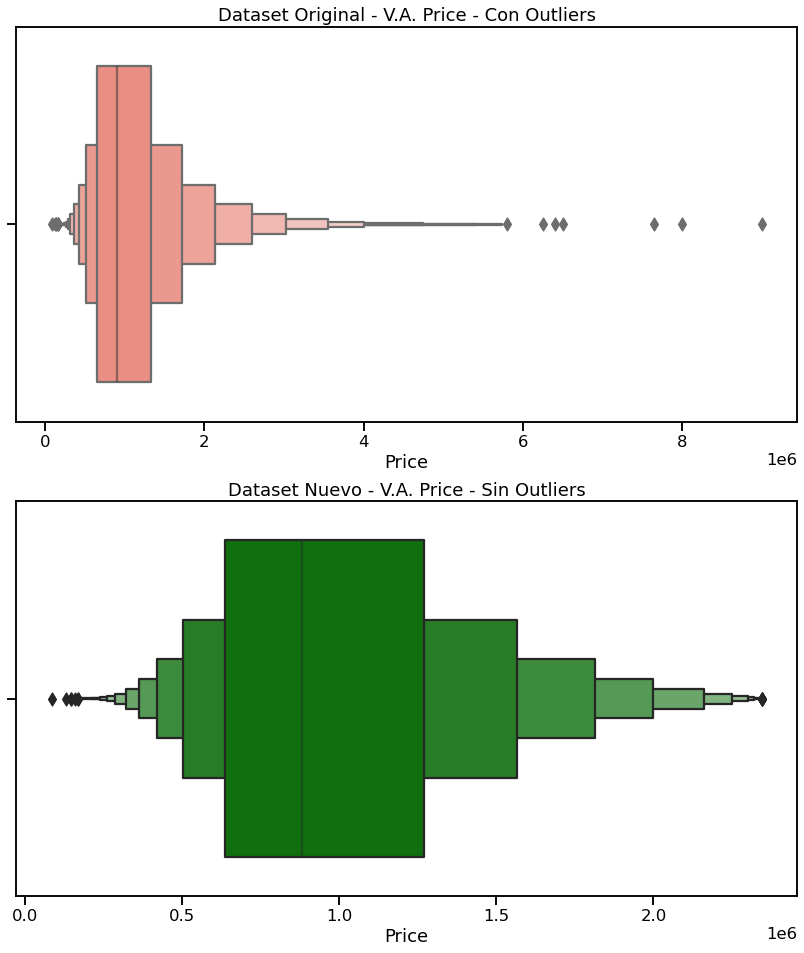

In [29]:
fig, axes = plt.subplots(2, 1,figsize=(14,16))

sns.boxenplot(data=melb_df, x="Price", color='salmon', ax=axes[0])
axes[0].title.set_text('Dataset Original - V.A. Price - Con Outliers')
sns.boxenplot(data=melb_df_2, x="Price", color='green', ax=axes[1])
axes[1].title.set_text('Dataset Nuevo - V.A. Price - Sin Outliers')

plt.show()

Observamos, que la concentración de los valores es mas uniforme y concentrados. Donde los valores extremos superiores fueron quitados, dejando así un dataset más homogeneos y significativo para realizar el análisis. 

Volvemos a describir la columna PRICE de este nuevo dataset para visualizar sus caracteristicas: 

In [30]:
melb_df_2[['Price']].describe().round(2)

,Price
count,12956.00
mean,981359.29
std,452925.15
min,85000.00
25%,637000.00
50%,880000.00
75%,1270000.00
max,2345000.00


In [31]:
print('Mediana:',melb_df_2[['Price']].median())

Mediana: Price    880000.0
dtype: float64


---

#### Conclusión 1.1

Podes concluir, que quitar oultiers nos benefició en: 

*   El valor mínimo para el precio queda en 85.000 USD y el nuevo máximo es 2.345.000 USD. 
* Nuestro nuevo valor de media es 981.359 USD.
* La mediana no sufrió tanto movimiento como si fue el de la media.
* La desviación estandar bajó por 200.000 lo cual nos dice que los datos están menos dispersos.

---

### Actividad 2

**CONSIGNA**

> Investigar la distribución de las variables del conjunto de datos y seleccionar un subconjunto de columnas que les parezcan relevantes al problema de predicción del valor de la propiedad.

    1. Justificar cada columna no seleccionada.
    2. Para las variables categóricas seleccionadas, agrupe o combine las categorías poco frecuentes para asegurar que todos los grupos tengan un número mínimo de registros.

Visualizamos una vez más el nuevo dataset transformado, el cual se trabajo la quita de los outliers: 

In [32]:
melb_df_2.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-03-12,2.5,3067,2.0,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,2016-04-02,2.5,3067,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,2017-04-03,2.5,3067,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,2017-04-03,2.5,3067,3.0,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,2016-04-06,2.5,3067,3.0,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


Con la observación de los datos y la definición de las columanos, podemos considerar cuales serán descartadas y cuales son de mayor relevancias y ser tomadas en el análisis.

Para corroborar que la elección es la correcta, se analizaran las caracteristicas de las mismas. 

In [33]:
cols_2b_discarded = ['Method', 'SellerG', 'Bedroom2', 'Propertycount']

In [34]:
melb_df_2[cols_2b_discarded].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12956 entries, 0 to 13579
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Method         12956 non-null  object 
 1   SellerG        12956 non-null  object 
 2   Bedroom2       12956 non-null  float64
 3   Propertycount  12956 non-null  float64
dtypes: float64(2), object(2)
memory usage: 506.1+ KB


In [35]:
melb_df_2[cols_2b_discarded].describe()

,Bedroom2,Propertycount
count,12956.000000,12956.000000
mean,2.862998,7454.598642
std,0.939786,4427.957030
min,0.000000,249.000000
25%,2.000000,4294.000000
50%,3.000000,6543.000000
75%,3.000000,10331.000000
max,20.000000,21650.000000


Observamos los valores nulos de estas columnas a descartar.

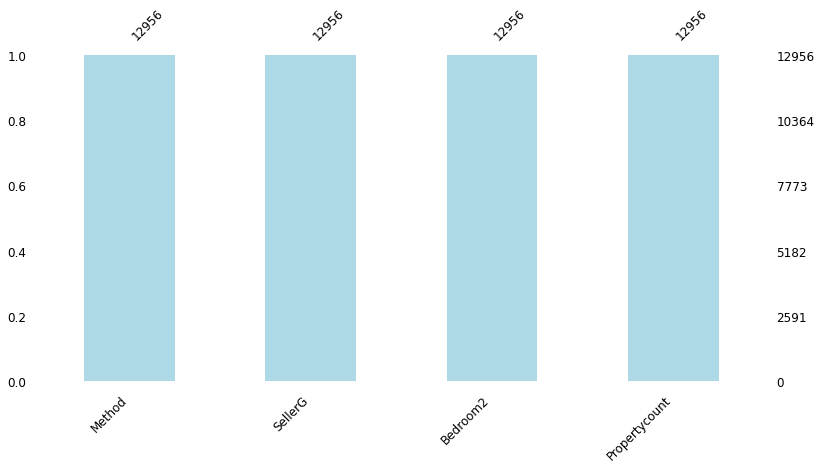

In [36]:
plt.figure(figsize=(13, 6))
msno.bar(melb_df_2[cols_2b_discarded],figsize=(13, 6), fontsize=12, color='lightblue')
plt.show()

Analizamos la presencia de valores 0 sobre las posibles variables a descartar.

In [37]:
meld_disc = melb_df_2[cols_2b_discarded]
cols = meld_disc[meld_disc == 0].count(axis=0)
cols

Method            0
SellerG           0
Bedroom2         15
Propertycount     0
dtype: int64

Observamos que dentro de las columnas que queremos descartar, Bedroom2 es la única que posee valores en 0, lo cual tiene cierta lógica según la definición dada por quién ofrece el dataset.

Llegado a este punto nos surge la siguiente pregunta: **¿Qué ocurre con las columnas que no queremos descartar?**

Analizaremos si estas tienen valores en 0 y/o nulos.

In [38]:
meld_no_disc = melb_df_2[['Suburb', 'Address', 'Rooms', 'Type', 'Price','Date', 'Distance', 'Bathroom', 'Car','CouncilArea', 'Postcode', 'Lattitude', 'Longtitude',
                     'Landsize', 'BuildingArea', 'YearBuilt','Regionname']]
cols = meld_no_disc[meld_no_disc == 0].count(axis=0)
cols

Suburb             0
Address            0
Rooms              0
Type               0
Price              0
Date               0
Distance           6
Bathroom          34
Car              998
CouncilArea        0
Postcode           0
Lattitude          0
Longtitude         0
Landsize        1926
BuildingArea      13
YearBuilt          0
Regionname         0
dtype: int64

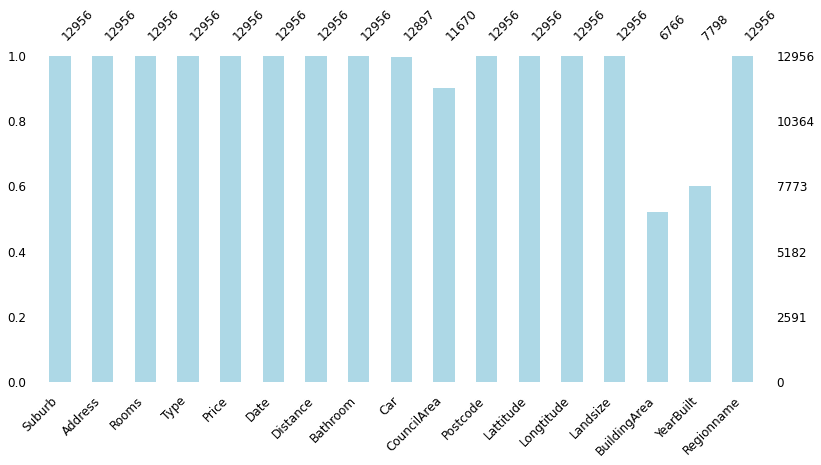

In [39]:
msno.bar(meld_no_disc,figsize=(13, 6), fontsize=12, color='lightblue')
plt.show()

<AxesSubplot:>

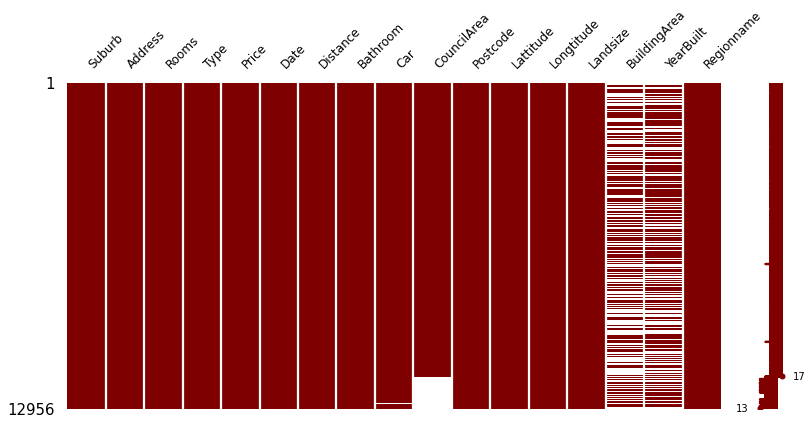

In [40]:
msno.matrix(meld_no_disc,figsize=(13, 6), fontsize=12, color=[0.5,0,0])

Vemos que las columnas con mayor cantidad de registros en 0 es **Landsize** y en cuanto a valores nulos, **BuildingArea** y **YearBuilt** son las más afectadas.

Por el momento, estas no serán descartadas, ya que puede que sus datos sean salvados y/o imputados.

Siguiendo con el análisis de las columnas descartadas, vemos los valores de la columna **SellerG** para ver qué contiene específicamente.

In [41]:
print(melb_df_2.SellerG.unique())
print(len(melb_df_2.SellerG.unique()))

['Biggin' 'Nelson' 'Jellis' 'Greg' 'LITTLE' 'Collins' 'Kay' 'Beller'
 'Marshall' 'Brad' 'Maddison' 'Barry' 'Considine' 'Rendina' 'Propertyau'
 'McDonald' 'Prof.' 'Harcourts' 'hockingstuart' 'Thomson' 'RT' "Sotheby's"
 'Cayzer' 'Chisholm' 'Brace' 'Miles' 'McGrath' 'Love' 'Barlow' 'Sweeney'
 'Village' 'Jas' 'Gunn&Co' 'Burnham' 'Williams' 'Compton' 'FN'
 'Raine&Horne' 'Hunter' 'Noel' 'Hodges' 'Ray' 'Gary' 'Fletchers'
 'Woodards' 'Raine' 'Walshe' 'Alexkarbon' 'Weda' 'Frank' 'Stockdale'
 'Buxton' 'Tim' 'Purplebricks' 'Moonee' 'HAR' 'Edward' 'Philip' 'North'
 'Ascend' 'Christopher' 'Mandy' 'RW' 'R&H' 'Fletchers/One' 'One' "O'Brien"
 'C21' 'Bayside' 'Paul' 'First' 'Matthew' 'Anderson' 'Nick' 'Lindellas'
 'Allens' 'Bells' 'Trimson' 'Douglas' 'YPA' 'GL' "Tiernan's" 'J'
 'Harrington' 'Dingle' 'Chambers' 'Peter' 'Grantham'
 'hockingstuart/Advantage' "O'Donoghues" 'Bekdon' 'Ross' 'Garvey'
 'Century' 'Kelly' 'Property' "Private/Tiernan's" 'Australian' 'Rodney'
 "Abercromby's" 'Castran' 'iTRAK' 'Del

Podemos concluir rápidamente, que una propiedad puede ser vendida por mas de un Gerente de Ventas y si el precio varía dependiendo el mismo, no creemos que influya a grandes rasgos.

Daremos un análisis a la columna Bedroom2, la cual deseamos descartar, porque consideramos poco relevante para el análisis el hecho de tener o no una columna que nos indica "Habitación de huespedes" cuando ya se especifica la cantidad de habitaciones de una propiedad. 

In [42]:
pd.crosstab(melb_df_2.Bedroom2,melb_df_2.Rooms)

Rooms,1,2,3,4,5,6,7,8,10
Bedroom2,,,,,,,,,
0.0,0,5,8,2,0,0,0,0,0
1.0,662,20,5,2,0,0,0,0,0
2.0,16,3526,160,18,1,0,0,0,0
3.0,2,73,5505,160,13,1,0,0,0
4.0,0,8,66,2189,27,4,0,1,0
5.0,0,1,5,12,394,1,1,0,0
6.0,0,0,0,0,0,49,0,2,0
7.0,0,0,0,0,1,1,6,0,0
8.0,0,0,0,0,1,0,0,4,0


#### Columnas Descartadas
* Method: Otra de las columnas poco relevantes, porque nos dice cómo fue vendida.
* SellerG: Variable ya analizada con anterioridad, y que justificamos diciendo que el vendedor puede ser cualquier persona, que no consideramos que influya demasiado en el valor de la propiedad.
* Bedroom2: Ya visto anteriormente, consideramos que anunciando la cantidad de habitaciones es suficiente para el análisis.
* Propertycount: Descartada porque no consideramos que influya la cantidad de propiedades en el precio final de la propiedad a analizar.

---

#### Columnas Seleccionadas

In [43]:
relevant_columns = ['Suburb', 'Address', 'Rooms', 'Type', 'Price','Date', 'Distance', 'Bathroom', 'Car', 'CouncilArea', 'Postcode', 'Lattitude', 'Longtitude',
                    'Landsize', 'BuildingArea', 'YearBuilt','Regionname']

Creamos un nuevo dataset para el análisis requerido:

In [44]:
melb_df_RC = melb_df_2[relevant_columns]
melb_df_RC

,Suburb,Address,Rooms,Type,Price,Date,Distance,Bathroom,Car,CouncilArea,Postcode,Lattitude,Longtitude,Landsize,BuildingArea,YearBuilt,Regionname
0,Abbotsford,85 Turner St,2,h,1480000.0,2016-03-12,2.5,1.0,1.0,Yarra,3067,-37.79960,144.99840,202.0,NaN,NaN,Northern Metropolitan
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,2016-04-02,2.5,1.0,0.0,Yarra,3067,-37.80790,144.99340,156.0,79.0,1900.0,Northern Metropolitan
2,Abbotsford,5 Charles St,3,h,1465000.0,2017-04-03,2.5,2.0,0.0,Yarra,3067,-37.80930,144.99440,134.0,150.0,1900.0,Northern Metropolitan
3,Abbotsford,40 Federation La,3,h,850000.0,2017-04-03,2.5,2.0,1.0,Yarra,3067,-37.79690,144.99690,94.0,NaN,NaN,Northern Metropolitan
4,Abbotsford,55a Park St,4,h,1600000.0,2016-04-06,2.5,1.0,2.0,Yarra,3067,-37.80720,144.99410,120.0,142.0,2014.0,Northern Metropolitan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13574,Westmeadows,9 Black St,3,h,582000.0,2017-08-26,16.5,2.0,2.0,NaN,3049,-37.67917,144.89390,256.0,NaN,NaN,Northern Metropolitan
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,2017-08-26,16.7,2.0,2.0,NaN,3150,-37.90562,145.16761,652.0,NaN,1981.0,South-Eastern Metropolitan
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,2017-08-26,6.8,2.0,2.0,NaN,3016,-37.85927,144.87904,333.0,133.0,1995.0,Western Metropolitan
13577,Williamstown,83 Power St,3,h,1170000.0,2017-08-26,6.8,2.0,4.0,NaN,3016,-37.85274,144.88738,436.0,NaN,1997.0,Western Metropolitan


Visualizamos la cantidad de valores únicos dentro de las variables seleccionadas.

In [45]:
melb_df_RC.nunique()

Suburb            314
Address         12771
Rooms               9
Type                3
Price            1945
Date               58
Distance          202
Bathroom            8
Car                11
CouncilArea        33
Postcode          198
Lattitude        6339
Longtitude       6882
Landsize         1398
BuildingArea      550
YearBuilt         135
Regionname          8
dtype: int64

In [46]:
melb_df_RC.describe().round(2)

,Rooms,Price,Distance,Bathroom,Car,Lattitude,Longtitude,Landsize,BuildingArea,YearBuilt
count,12956.00,12956.00,12956.00,12956.00,12897.00,12956.00,12956.00,12956.00,6766.00,7798.00
mean,2.88,981359.29,10.24,1.49,1.58,-37.81,144.99,517.12,145.00,1965.77
std,0.93,452925.15,5.95,0.64,0.95,0.08,0.11,1498.21,552.86,36.56
min,1.00,85000.00,0.00,0.00,0.00,-38.18,144.43,0.00,0.00,1196.00
25%,2.00,637000.00,6.20,1.00,1.00,-37.86,144.93,168.00,91.00,1950.00
50%,3.00,880000.00,9.40,1.00,2.00,-37.80,145.00,416.00,122.00,1970.00
75%,3.00,1270000.00,13.00,2.00,2.00,-37.75,145.06,645.00,165.00,2000.00
max,10.00,2345000.00,48.10,8.00,10.00,-37.41,145.53,76000.00,44515.00,2018.00


Analizaremos las columnas que podemos agrupar.

Tomaremos en primera instancia, las variables categorícas **Regionname** y **YearBuilt**.

---

##### Agrupamiento **Regionname**

Observamos los valores únicos para **Regionname** y la cantidad de valores que tienen.

In [47]:
melb_df_RC[['Regionname']].groupby(by=['Regionname']).size()

Regionname
Eastern Metropolitan          1435
Eastern Victoria                53
Northern Metropolitan         3846
Northern Victoria               41
South-Eastern Metropolitan     447
Southern Metropolitan         4177
Western Metropolitan          2925
Western Victoria                32
dtype: int64

Observando las columnas y la cantidad de valores de cada una, vamos a hacer clustering en 4 regiones:
* South (Sur)
* North (Norte)
* East (Este)
* West (Oeste)

Creamos un diccionario de las regiones con su nueva definición

In [48]:
dic_region = {'Eastern Metropolitan': 'East', 'Eastern Victoria': 'East', 'Northern Metropolitan': 'North', 
              'Northern Victoria': 'North', 'South-Eastern Metropolitan': 'South', 'Southern Metropolitan': 'South',
              'Western Metropolitan': 'West', 'Western Victoria': 'West'}

Ya contando con el diccionario de las regiones, se reemplazará la región correspondiente para cada propiedad en el nuevo dataset determinado para el analisis.

In [49]:
melb_df_RC = melb_df_RC.replace({'Regionname': dic_region})
melb_df_RC[['Regionname']].groupby(by=['Regionname']).size()

Regionname
East     1488
North    3887
South    4624
West     2957
dtype: int64

---

##### Agrupamiento YearBuilt en AgeRange

Ahora trataremos con los valores de años de contrucción. Primero analizamos qué contiene nuestro datasets

In [50]:
melb_df_RC[['YearBuilt']].groupby(by=['YearBuilt']).size()

YearBuilt
1196.0     1
1830.0     1
1850.0     4
1856.0     1
1857.0     1
          ..
2014.0    98
2015.0    56
2016.0    50
2017.0    17
2018.0     1
Length: 135, dtype: int64

Analizaremos este dato con un gráfico, para comparar la frecuencia de los años de construcción de las propiedades del dataset. 

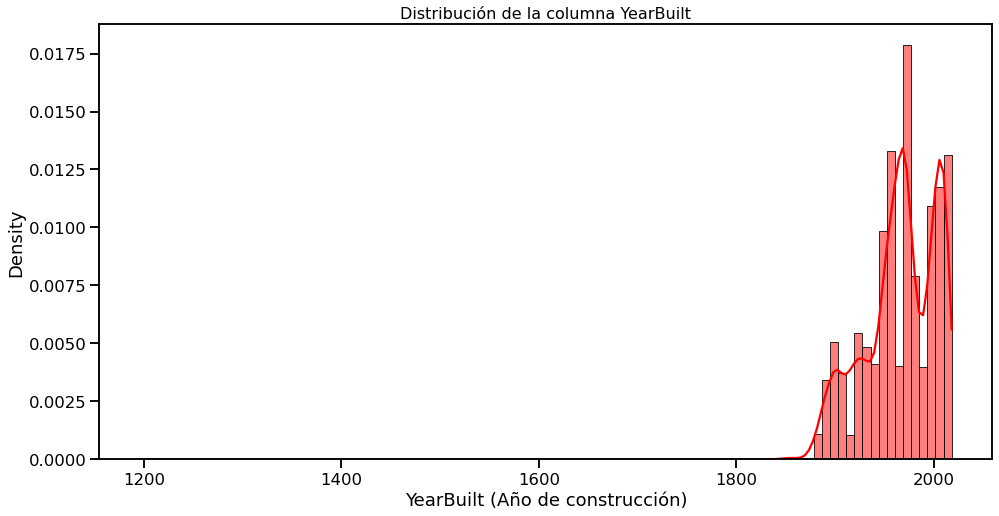

In [51]:
fig = plt.figure(figsize=(16, 8))
sns.histplot(data=melb_df_RC[['YearBuilt']], x="YearBuilt", kde=True, bins=100, color='red', stat= 'density')
plt.title('Distribución de la columna YearBuilt',fontsize=16)
plt.xlabel('YearBuilt (Año de construcción)')
plt.show()

Como vemos, hay valores desde antes de 1900. Analizaremos la concentración de datos.

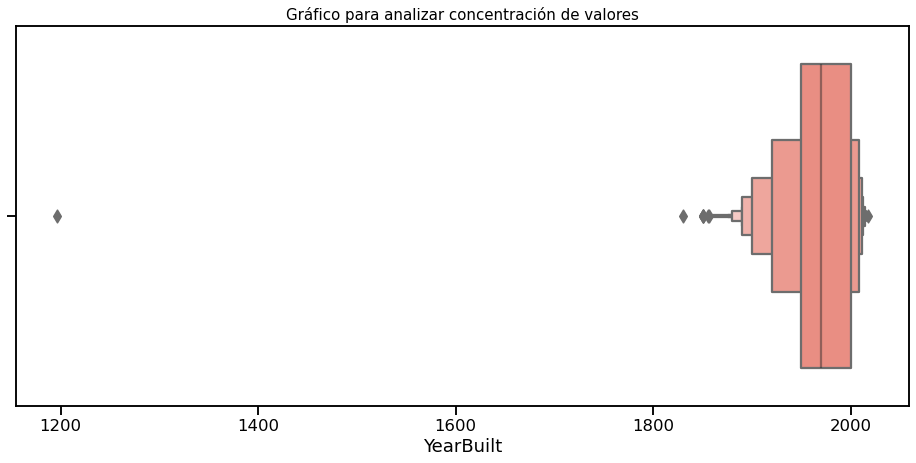

In [52]:
plt.figure(figsize=(16, 7))
sns.boxenplot(data=melb_df_RC[['YearBuilt']], x="YearBuilt", color='salmon')
plt.title("Gráfico para analizar concentración de valores", fontsize=15)
plt.show()

Observamos un outlier o un caso muy atípico que se presenta en una propiedad construida en 1196. Este pudo o no ser un dato mal tipificado, pero por el momento no tomamos decisiones de cambio sobre el registro.

Miraremos la concentración dentro de las propiedades construidas por encima de 1800.

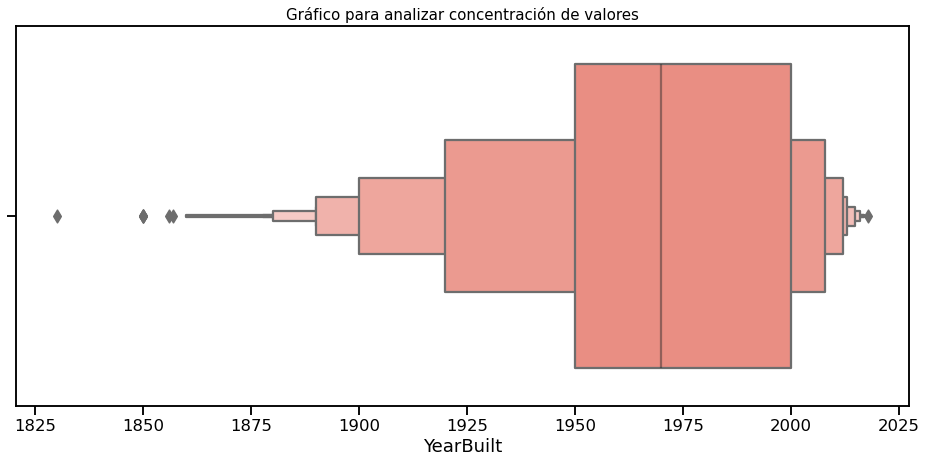

In [53]:
plt.figure(figsize=(16, 7))
sns.boxenplot(data=melb_df_RC[melb_df_RC.YearBuilt >= 1800], x="YearBuilt", color='salmon')
plt.title("Gráfico para analizar concentración de valores", fontsize=15)
plt.show()

In [54]:
melb_df_RC[melb_df_RC.YearBuilt >= 1800].describe().round(2)

,Rooms,Price,Distance,Bathroom,Car,Lattitude,Longtitude,Landsize,BuildingArea,YearBuilt
count,7797.00,7797.00,7797.00,7797.00,7769.00,7797.00,7797.00,7797.00,6509.00,7797.00
mean,2.87,961679.34,10.12,1.52,1.56,-37.81,144.99,481.60,135.92,1965.87
std,0.95,459087.62,6.01,0.65,0.92,0.08,0.10,1012.13,74.91,35.50
min,1.00,85000.00,0.00,0.00,0.00,-38.16,144.54,0.00,0.00,1830.00
25%,2.00,610000.00,6.10,1.00,1.00,-37.86,144.93,150.00,92.00,1950.00
50%,3.00,855000.00,9.20,1.00,1.00,-37.80,145.00,362.00,122.00,1970.00
75%,3.00,1250000.00,13.00,2.00,2.00,-37.76,145.05,624.00,164.00,2000.00
max,10.00,2345000.00,47.40,8.00,10.00,-37.41,145.53,37000.00,1561.00,2018.00


Como observamos, dentro de la columna **YearBuilt** existe el registro con valor 2018, generando un dato ruidoso con respecto a la columna **Date**, en donde el valor máximo de fecha es del año 2017.

Analicemos lo que pasa en este registro.

In [55]:
melb_df_RC[melb_df_RC.YearBuilt >= 2018]

,Suburb,Address,Rooms,Type,Price,Date,Distance,Bathroom,Car,CouncilArea,Postcode,Lattitude,Longtitude,Landsize,BuildingArea,YearBuilt,Regionname
1234,Brighton East,8 Thomas St,2,h,1310000.0,2016-09-24,10.7,3.0,2.0,Glen Eira,3187,-37.9182,145.0231,302.0,250.0,2018.0,South


Luego de este análisis, podemos deducir que hay propiedades que se venden, y posterio se construyen, porque en este registro de la columna **YearBuilt**, el año de construcción es posterior al año de la venta.

In [56]:
melb_df_RC[pd.DatetimeIndex(melb_df_RC['Date']).year < melb_df_RC.YearBuilt]

,Suburb,Address,Rooms,Type,Price,Date,Distance,Bathroom,Car,CouncilArea,Postcode,Lattitude,Longtitude,Landsize,BuildingArea,YearBuilt,Regionname
441,Avondale Heights,157 Canning St,3,t,851000.0,2016-03-12,10.5,3.0,1.0,Moonee Valley,3034,-37.7700,144.8572,557.0,181.0,2017.0,West
1234,Brighton East,8 Thomas St,2,h,1310000.0,2016-09-24,10.7,3.0,2.0,Glen Eira,3187,-37.9182,145.0231,302.0,250.0,2018.0,South
3489,Keilor East,20 Keith Gr,3,h,825000.0,2016-04-23,12.8,2.0,1.0,Moonee Valley,3033,-37.7378,144.8705,630.0,126.0,2017.0,West
4282,Newport,7 Durkin St,3,h,945000.0,2016-05-28,8.4,2.0,1.0,Hobsons Bay,3015,-37.8438,144.8806,487.0,190.0,2017.0,West
5153,Reservoir,89 Darebin Bvd,4,h,767500.0,2016-09-17,11.2,2.0,2.0,Darebin,3073,-37.7040,145.0299,834.0,129.0,2017.0,North
7060,Heidelberg,36 Buckingham Dr,3,h,1030000.0,2016-07-30,10.6,3.0,2.0,Banyule,3084,-37.7501,145.0822,649.0,357.0,2017.0,East


Podemos concluir, que para este caso, existen varias propiedades (5), con el año de construcción mayor al año de venta.

Crearemos una nueva columna, informando el rango de antiguedad correspondiente a cada propiedad según su año de construcción y fecha de venta.

In [57]:
melb_df_RC.head(10)

,Suburb,Address,Rooms,Type,Price,Date,Distance,Bathroom,Car,CouncilArea,Postcode,Lattitude,Longtitude,Landsize,BuildingArea,YearBuilt,Regionname
0,Abbotsford,85 Turner St,2,h,1480000.0,2016-03-12,2.5,1.0,1.0,Yarra,3067,-37.7996,144.9984,202.0,NaN,NaN,North
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,2016-04-02,2.5,1.0,0.0,Yarra,3067,-37.8079,144.9934,156.0,79.0,1900.0,North
2,Abbotsford,5 Charles St,3,h,1465000.0,2017-04-03,2.5,2.0,0.0,Yarra,3067,-37.8093,144.9944,134.0,150.0,1900.0,North
3,Abbotsford,40 Federation La,3,h,850000.0,2017-04-03,2.5,2.0,1.0,Yarra,3067,-37.7969,144.9969,94.0,NaN,NaN,North
4,Abbotsford,55a Park St,4,h,1600000.0,2016-04-06,2.5,1.0,2.0,Yarra,3067,-37.8072,144.9941,120.0,142.0,2014.0,North
5,Abbotsford,129 Charles St,2,h,941000.0,2016-07-05,2.5,1.0,0.0,Yarra,3067,-37.8041,144.9953,181.0,NaN,NaN,North
6,Abbotsford,124 Yarra St,3,h,1876000.0,2016-07-05,2.5,2.0,0.0,Yarra,3067,-37.8024,144.9993,245.0,210.0,1910.0,North
7,Abbotsford,98 Charles St,2,h,1636000.0,2016-08-10,2.5,1.0,2.0,Yarra,3067,-37.8060,144.9954,256.0,107.0,1890.0,North
8,Abbotsford,6/241 Nicholson St,1,u,300000.0,2016-08-10,2.5,1.0,1.0,Yarra,3067,-37.8008,144.9973,0.0,NaN,NaN,North
9,Abbotsford,10 Valiant St,2,h,1097000.0,2016-08-10,2.5,1.0,2.0,Yarra,3067,-37.8010,144.9989,220.0,75.0,1900.0,North


In [58]:
melb_df_RC['Antiquity'] = pd.DatetimeIndex(melb_df_RC['Date']).year - melb_df_RC['YearBuilt']
melb_df_RC.loc[melb_df_RC['Antiquity'] < 0, 'Antiquity'] = 0
print('Cantidad de valores únicos:', melb_df_RC['Antiquity'].nunique())
print(melb_df_RC[['Antiquity']].info())

Cantidad de valores únicos: 144
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12956 entries, 0 to 13579
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Antiquity  7798 non-null   float64
dtypes: float64(1)
memory usage: 202.4 KB
None


Al ver que tenemos 144 valores, distintos para antigüedad, procedemos a crear la columna de rango de antiguedad.

In [59]:
def year_range(value):
        if value >= 70:
            return '[>70)'
        else:
            low_limit = value//5
            agerange = "["+str(int(low_limit*5))+"-"+str(int(low_limit*5+5))+")"
            return agerange        

In [60]:
#melb_df_RC['AgeRange'] = melb_df_RC['Antiquity'].apply(year_range)
melb_df_RC['AgeRange'] = melb_df_RC[melb_df_RC['Antiquity'].isna()==False]['Antiquity'].apply(year_range)
melb_df_RC.loc[melb_df_RC['AgeRange'].isnull(), 'AgeRange'] = 'S/D'
melb_df_RC.AgeRange.unique()

array(['S/D', '[>70)', '[0-5)', '[10-15)', '[5-10)', '[30-35)', '[45-50)',
       '[65-70)', '[15-20)', '[50-55)', '[35-40)', '[40-45)', '[20-25)',
       '[55-60)', '[60-65)', '[25-30)'], dtype=object)

##### Distribución

A partir de este punto, comenzaremos a realizar las distribuciones por precio de las propiedades respecto a las variables escogidas.

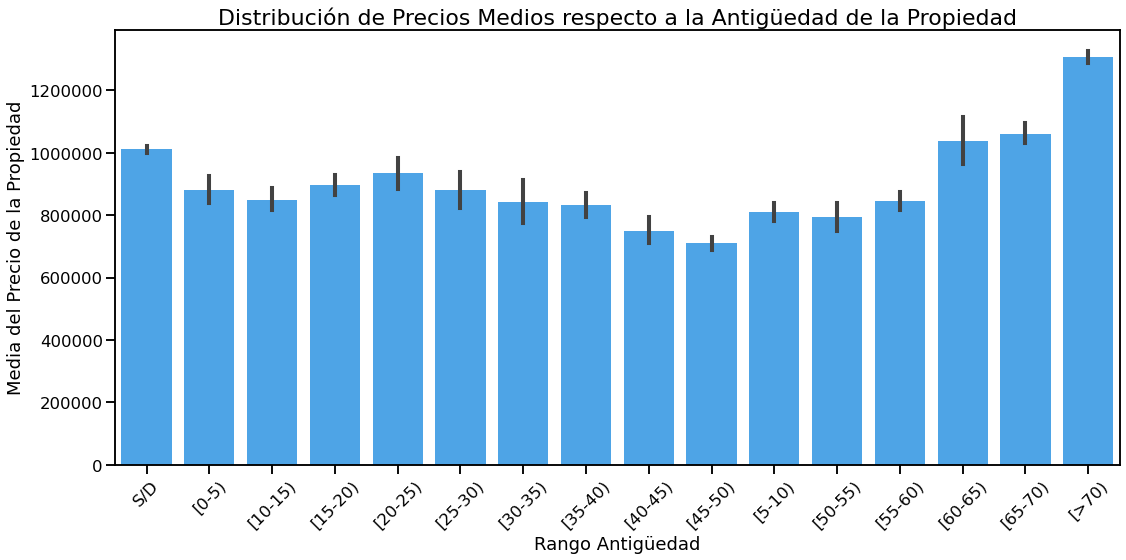

In [61]:
PriceToAgeRange = melb_df_RC[['AgeRange','Price']].sort_values(by=['AgeRange'])
fig = plt.figure(figsize=(18, 8))
ax = sns.barplot(x='AgeRange', y='Price', data=PriceToAgeRange, color='#35A7FF')
plt.xticks(rotation=45)
plt.title('Distribución de Precios Medios respecto a la Antigüedad de la Propiedad',fontsize=22)
plt.ylabel("Media del Precio de la Propiedad")
plt.xlabel("Rango Antigüedad")
plt.ticklabel_format(style='plain', axis='y')
plt.show()

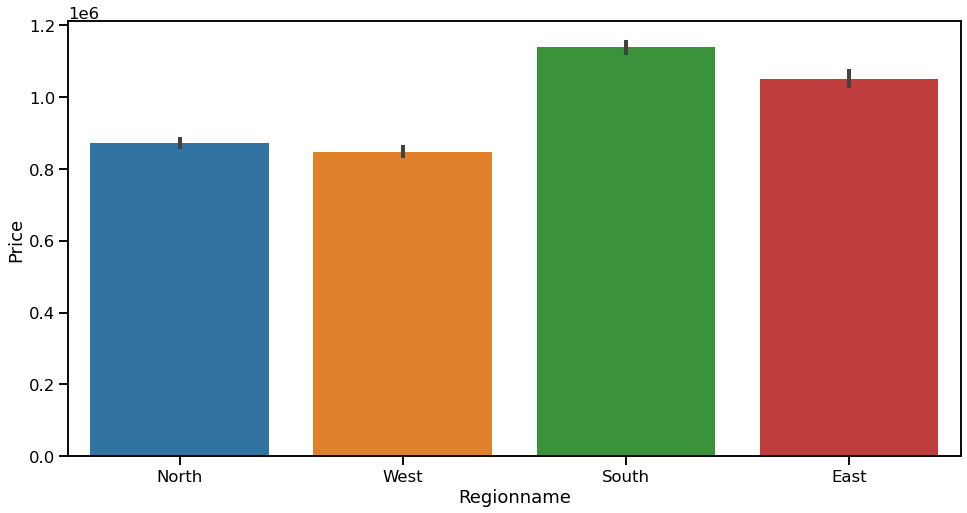

In [62]:
fig = plt.figure(figsize=(16, 8))
ax = sns.barplot(x='Regionname', y='Price', data=melb_df_RC)
plt.show()

Borrado de las columnas que nos ayudaron a agrupar.

In [63]:
melb_df_RC.drop(columns=['Antiquity'],inplace=True)
melb_df_RC

,Suburb,Address,Rooms,Type,Price,Date,Distance,Bathroom,Car,CouncilArea,Postcode,Lattitude,Longtitude,Landsize,BuildingArea,YearBuilt,Regionname,AgeRange
0,Abbotsford,85 Turner St,2,h,1480000.0,2016-03-12,2.5,1.0,1.0,Yarra,3067,-37.79960,144.99840,202.0,NaN,NaN,North,S/D
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,2016-04-02,2.5,1.0,0.0,Yarra,3067,-37.80790,144.99340,156.0,79.0,1900.0,North,[>70)
2,Abbotsford,5 Charles St,3,h,1465000.0,2017-04-03,2.5,2.0,0.0,Yarra,3067,-37.80930,144.99440,134.0,150.0,1900.0,North,[>70)
3,Abbotsford,40 Federation La,3,h,850000.0,2017-04-03,2.5,2.0,1.0,Yarra,3067,-37.79690,144.99690,94.0,NaN,NaN,North,S/D
4,Abbotsford,55a Park St,4,h,1600000.0,2016-04-06,2.5,1.0,2.0,Yarra,3067,-37.80720,144.99410,120.0,142.0,2014.0,North,[0-5)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13574,Westmeadows,9 Black St,3,h,582000.0,2017-08-26,16.5,2.0,2.0,NaN,3049,-37.67917,144.89390,256.0,NaN,NaN,North,S/D
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,2017-08-26,16.7,2.0,2.0,NaN,3150,-37.90562,145.16761,652.0,NaN,1981.0,South,[35-40)
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,2017-08-26,6.8,2.0,2.0,NaN,3016,-37.85927,144.87904,333.0,133.0,1995.0,West,[20-25)
13577,Williamstown,83 Power St,3,h,1170000.0,2017-08-26,6.8,2.0,4.0,NaN,3016,-37.85274,144.88738,436.0,NaN,1997.0,West,[20-25)


---

### Actividad 3

Agregar información adicional respectiva al entorno de una propiedad a partir del [conjunto de datos de AirBnB](https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv) utilizado en el práctico. 

1. Seleccionar qué variables agregar y qué combinaciones aplicar a cada una. Por ejemplo, pueden utilizar solo la columna `price`, o aplicar múltiples transformaciones como la mediana o el mínimo.
2. Utilizar la variable zipcode para unir los conjuntos de datos. Sólo incluir los zipcodes que tengan una cantidad mínima de registros (a elección) como para que la información agregada sea relevante.
3. Investigar al menos otras 2 variables que puedan servir para combinar los datos, y justificar si serían adecuadas o no. Pueden asumir que cuentan con la ayuda de anotadores expertos para encontrar equivalencias entre barrios o direcciones, o que cuentan con algoritmos para encontrar las n ubicaciones más cercanas a una propiedad a partir de sus coordenadas geográficas. **NO** es necesario que realicen la implementación.

Pueden leer otras columnas del conjunto de AirBnB además de las que están en `interesting_cols`, si les parecen relevantes.

In [64]:
airbnb_df.head(10)

,description,neighborhood_overview,street,neighborhood,city,suburb,state,zipcode,latitude,longitude,price,weekly_price,monthly_price
0,"House: Clean, New, Modern, Quite, Safe. 10Km f...",Very safe! Family oriented. Older age group.,"Bulleen, VIC, Australia",Balwyn North,Manningham,Bulleen,VIC,3105,-37.772684,145.092133,60,NaN,NaN
1,A large air conditioned room with queen spring...,This hip area is a crossroads between two grea...,"Brunswick East, VIC, Australia",Brunswick,Moreland,Brunswick East,VIC,3057,-37.766505,144.980736,35,200.0,803.0
2,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,A stay at our apartment means you can enjoy so...,"St Kilda, VIC, Australia",St Kilda,Port Phillip,St Kilda,VIC,3182,-37.859755,144.977369,159,1253.0,4452.0
3,"Comfortable, relaxed house, a home away from ...","This is a great neighbourhood – it is quiet, y...","Thornbury, VIC, Australia",Thornbury,Darebin,Thornbury,VIC,3071,-37.758971,144.989228,50,250.0,920.0
4,We offer comfortable accommodation in Inner Me...,NaN,"St Kilda East, VIC, Australia",St Kilda East,Port Phillip,St Kilda East,VIC,3183,-37.864530,144.992238,69,400.0,1900.0
5,Please note: No booking will be accepted with ...,Our street is quiet & secluded but within walk...,"Berwick, VIC, Australia",NaN,Casey,Berwick,VIC,3806,-38.057254,145.339356,98,540.0,NaN
6,Easy to travel from and to the Airport; quiet ...,"The neighbours are quiet and friendly, please...","Reservoir, VIC, Australia",NaN,Darebin,Reservoir,VIC,3073,-37.697294,145.000816,50,335.0,1400.0
7,Comfortable and spacious room in an apartment ...,MCG (15min walk) Rod Laver Arena Fitzroy Garde...,"East Melbourne, VIC, Australia",NaN,Melbourne,East Melbourne,VIC,3002,-37.810267,144.985920,100,NaN,NaN
8,Study the exquisite detail of the antique Java...,Oakleigh is one of the most convenient and div...,"Oakleigh East, VIC, Australia",NaN,Monash,Oakleigh East,VIC,3166,-37.899601,145.114475,98,535.0,NaN
9,Light filled private room with Queen bed taste...,NaN,"Frankston, VIC, Australia",NaN,Frankston,Frankston,VIC,3199,-38.149320,145.141569,60,413.0,1540.0


#### Análisis y Curación Extra

In [65]:
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22895 entries, 0 to 22894
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   description            22563 non-null  object 
 1   neighborhood_overview  14424 non-null  object 
 2   street                 22895 non-null  object 
 3   neighborhood           17082 non-null  object 
 4   city                   22895 non-null  object 
 5   suburb                 22872 non-null  object 
 6   state                  22834 non-null  object 
 7   zipcode                22753 non-null  object 
 8   latitude               22895 non-null  float64
 9   longitude              22895 non-null  float64
 10  price                  22895 non-null  int64  
 11  weekly_price           2524 non-null   float64
 12  monthly_price          1891 non-null   float64
dtypes: float64(4), int64(1), object(8)
memory usage: 2.3+ MB


In [66]:
airbnb_df.describe()

,latitude,longitude,price,weekly_price,monthly_price
count,22895.000000,22895.000000,22895.000000,2524.000000,1891.000000
mean,-37.826827,145.008457,148.004368,906.976228,3234.346906
std,0.066747,0.127711,210.883253,821.223782,2808.092144
min,-38.224427,144.484326,0.000000,91.000000,400.000000
25%,-37.852665,144.957692,71.000000,450.000000,1700.000000
50%,-37.817855,144.978402,111.000000,750.000000,2800.000000
75%,-37.803176,145.013441,165.000000,1066.000000,3912.500000
max,-37.482595,145.839127,12624.000000,11536.000000,54258.000000


In [67]:
airbnb_df.isna().sum()

description                332
neighborhood_overview     8471
street                       0
neighborhood              5813
city                         0
suburb                      23
state                       61
zipcode                    142
latitude                     0
longitude                    0
price                        0
weekly_price             20371
monthly_price            21004
dtype: int64

##### Columnas **zipcode**

In [72]:
airbnb_df.zipcode.str.len().unique()

array([4, 3], dtype=int64)

El código postal debe tener un largo de 4 dígitos, por lo que listaremos los códigos postales del DataFrame

In [69]:
airbnb_df.zipcode.unique()

array(['3105', '3057', '3182', '3071', '3183', '3806', '3073', '3002',
       '3166', '3199', '3121', '3000', '3187', '3101', '3065', '3188',
       '3068', '3195', '3070', '3207', '3205', '3181', '3135', '3052',
       '3004', '3013', '3160', '3777', '3079', '3184', '3149', '3206',
       '3123', '3053', '3161', '3094', '3056', '3046', '3051', '3066',
       '3006', '3141', '3130', '3023', '3159', '3162', '3030', '3167',
       '3186', '3067', '3015', '3143', '3103', '3910', '3980', '3029',
       '3084', '3185', '3144', '3145', '3031', '3104', '3012', '3072',
       '3191', '3058', '3074', '3775', '3163', nan, '30122', '3147',
       '3789', '3175', '3099', '3018', '3011', '3078', '3788', '3107',
       '3042', '3040', '3178', '3134', '3089', '3142', '3911', '3168',
       '3008', '3129', '3146', '3190', '3088', '3193', '3131', '3204',
       '3032', '3109', '3797', '3782', '3003', 'VIC 3161', '3113', '3081',
       '3158', '3122', '3136', '3140', '3076', '3153', '3977', '3044',
    

In [70]:
airbnb_df.zipcode = airbnb_df.zipcode.str.extract('(\d+)').rename(columns={0:'zipcode'}).zipcode.str[0:4]
airbnb_df.zipcode = airbnb_df.zipcode.astype(str)
airbnb_df.head()

,description,neighborhood_overview,street,neighborhood,city,suburb,state,zipcode,latitude,longitude,price,weekly_price,monthly_price
0,"House: Clean, New, Modern, Quite, Safe. 10Km f...",Very safe! Family oriented. Older age group.,"Bulleen, VIC, Australia",Balwyn North,Manningham,Bulleen,VIC,3105,-37.772684,145.092133,60,NaN,NaN
1,A large air conditioned room with queen spring...,This hip area is a crossroads between two grea...,"Brunswick East, VIC, Australia",Brunswick,Moreland,Brunswick East,VIC,3057,-37.766505,144.980736,35,200.0,803.0
2,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,A stay at our apartment means you can enjoy so...,"St Kilda, VIC, Australia",St Kilda,Port Phillip,St Kilda,VIC,3182,-37.859755,144.977369,159,1253.0,4452.0
3,"Comfortable, relaxed house, a home away from ...","This is a great neighbourhood – it is quiet, y...","Thornbury, VIC, Australia",Thornbury,Darebin,Thornbury,VIC,3071,-37.758971,144.989228,50,250.0,920.0
4,We offer comfortable accommodation in Inner Me...,NaN,"St Kilda East, VIC, Australia",St Kilda East,Port Phillip,St Kilda East,VIC,3183,-37.864530,144.992238,69,400.0,1900.0


In [71]:
airbnb_df.zipcode

0        3105
1        3057
2        3182
3        3071
4        3183
         ... 
22890    3053
22891    3338
22892    3150
22893    3006
22894    3053
Name: zipcode, Length: 22895, dtype: object

In [73]:
print('Código postal mínimo:', min(airbnb_df.zipcode.values))
print('Código postal máximo:', max(airbnb_df.zipcode.values))

Código postal mínimo: 2010
Código postal máximo: nan


Como se considera hacer la unión por zipcode, eliminaremos nan y aquellos menores/iguales a 3000 y mayores a 4000.

In [82]:
airbnb_df = airbnb_df[(airbnb_df.zipcode >= '3000') & (airbnb_df.zipcode < '4000')].reset_index(drop=['index'])
airbnb_df

,description,neighborhood_overview,street,neighborhood,city,suburb,state,zipcode,latitude,longitude,price,weekly_price,monthly_price
0,"House: Clean, New, Modern, Quite, Safe. 10Km f...",Very safe! Family oriented. Older age group.,"Bulleen, VIC, Australia",Balwyn North,Manningham,Bulleen,VIC,3105,-37.772684,145.092133,60,NaN,NaN
1,A large air conditioned room with queen spring...,This hip area is a crossroads between two grea...,"Brunswick East, VIC, Australia",Brunswick,Moreland,Brunswick East,VIC,3057,-37.766505,144.980736,35,200.0,803.0
2,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,A stay at our apartment means you can enjoy so...,"St Kilda, VIC, Australia",St Kilda,Port Phillip,St Kilda,VIC,3182,-37.859755,144.977369,159,1253.0,4452.0
3,"Comfortable, relaxed house, a home away from ...","This is a great neighbourhood – it is quiet, y...","Thornbury, VIC, Australia",Thornbury,Darebin,Thornbury,VIC,3071,-37.758971,144.989228,50,250.0,920.0
4,We offer comfortable accommodation in Inner Me...,NaN,"St Kilda East, VIC, Australia",St Kilda East,Port Phillip,St Kilda East,VIC,3183,-37.864530,144.992238,69,400.0,1900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22735,"near city, near tram station",NaN,"Carlton, VIC, Australia",Carlton,Melbourne,Carlton,VIC,3053,-37.802415,144.962967,55,NaN,NaN
22736,"Close to: Melton Rail, Coles, Coffee Lounge an...",NaN,"Melton South, VIC, Australia",NaN,Melton,Melton South,VIC,3338,-37.705095,144.574474,129,NaN,NaN
22737,"Hi, 我是一名中国留学生. 由于暑假原因决定出租我的房间. 我会留下我所使用的物品给我的租...",NaN,"Glen Waverley, VIC, Australia",NaN,Monash,Glen Waverley,VIC,3150,-37.875252,145.162757,53,NaN,NaN
22738,Immaculately presented and carefully maintaine...,A plethora of Melbourne highlights are just a ...,"Southbank, VIC, Australia",Southbank,Melbourne,Southbank,VIC,3006,-37.827795,144.954987,130,NaN,NaN


##### Columna **price**

Distribución de la columnas **price**

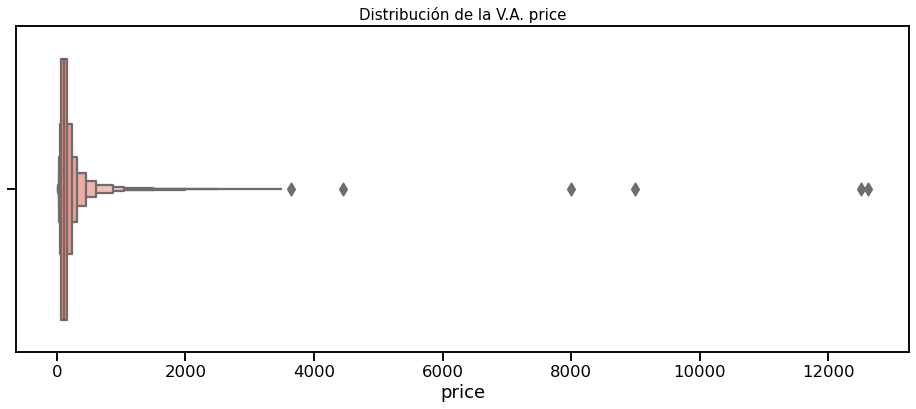

In [83]:
plt.figure(figsize=(16, 6))
sns.boxenplot(data=airbnb_df, x="price", color='salmon')
plt.title("Distribución de la V.A. price", fontsize=15)
plt.show()

In [84]:
RIair, BIair, BSair = range_interquantile(airbnb_df, 'price')

print('Rango Intercuartil:',RIair)
print('Bigote Inferior:', BIair)
print('Bigote Superior:',BSair)

Rango Intercuartil: 94.0
Bigote Inferior: -70.0
Bigote Superior: 306.0


In [85]:
airbnb_df.price.describe()

count    22740.000000
mean       147.905629
std        210.986228
min          0.000000
25%         71.000000
50%        109.000000
75%        165.000000
max      12624.000000
Name: price, dtype: float64

Procederemos entonces a sacar los outliers de airbnb_df en un nuevo dataset:

In [86]:
outliers = len(airbnb_df[airbnb_df['price'] > BSair])
print('Datos considerados como Outliers:', outliers)

Datos considerados como Outliers: 1432


In [87]:
airbnb_df[airbnb_df['price'] > BSair].describe().round(2)

,latitude,longitude,price,weekly_price,monthly_price
count,1432.00,1432.00,1432.00,157.00,108.00
mean,-37.83,145.04,604.57,2788.08,9148.41
std,0.08,0.17,652.35,1776.21,5901.48
min,-38.19,144.59,307.00,280.00,550.00
25%,-37.86,144.96,375.00,1899.00,6150.00
50%,-37.82,144.98,450.00,2445.00,7985.00
75%,-37.81,145.02,610.00,3150.00,10050.00
max,-37.52,145.71,12624.00,11536.00,36835.00


In [88]:
airbnb_df_2 = remove_outliers(airbnb_df, 'price')
airbnb_df_2

,description,neighborhood_overview,street,neighborhood,city,suburb,state,zipcode,latitude,longitude,price,weekly_price,monthly_price
0,"House: Clean, New, Modern, Quite, Safe. 10Km f...",Very safe! Family oriented. Older age group.,"Bulleen, VIC, Australia",Balwyn North,Manningham,Bulleen,VIC,3105,-37.772684,145.092133,60,NaN,NaN
1,A large air conditioned room with queen spring...,This hip area is a crossroads between two grea...,"Brunswick East, VIC, Australia",Brunswick,Moreland,Brunswick East,VIC,3057,-37.766505,144.980736,35,200.0,803.0
2,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,A stay at our apartment means you can enjoy so...,"St Kilda, VIC, Australia",St Kilda,Port Phillip,St Kilda,VIC,3182,-37.859755,144.977369,159,1253.0,4452.0
3,"Comfortable, relaxed house, a home away from ...","This is a great neighbourhood – it is quiet, y...","Thornbury, VIC, Australia",Thornbury,Darebin,Thornbury,VIC,3071,-37.758971,144.989228,50,250.0,920.0
4,We offer comfortable accommodation in Inner Me...,NaN,"St Kilda East, VIC, Australia",St Kilda East,Port Phillip,St Kilda East,VIC,3183,-37.864530,144.992238,69,400.0,1900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22890,"near city, near tram station",NaN,"Carlton, VIC, Australia",Carlton,Melbourne,Carlton,VIC,3053,-37.802415,144.962967,55,NaN,NaN
22891,"Close to: Melton Rail, Coles, Coffee Lounge an...",NaN,"Melton South, VIC, Australia",NaN,Melton,Melton South,VIC,3338,-37.705095,144.574474,129,NaN,NaN
22892,"Hi, 我是一名中国留学生. 由于暑假原因决定出租我的房间. 我会留下我所使用的物品给我的租...",NaN,"Glen Waverley, VIC, Australia",NaN,Monash,Glen Waverley,VIC,3150,-37.875252,145.162757,53,NaN,NaN
22893,Immaculately presented and carefully maintaine...,A plethora of Melbourne highlights are just a ...,"Southbank, VIC, Australia",Southbank,Melbourne,Southbank,VIC,3006,-37.827795,144.954987,130,NaN,NaN


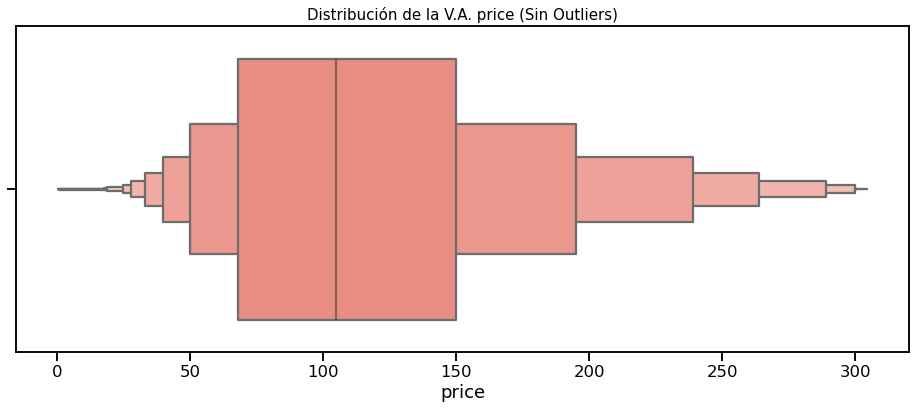

In [89]:
plt.figure(figsize=(16, 6))
sns.boxenplot(data=airbnb_df_2, x="price", color='salmon')
plt.title("Distribución de la V.A. price (Sin Outliers)", fontsize=15)
plt.show()

##### Análisis de Nulos

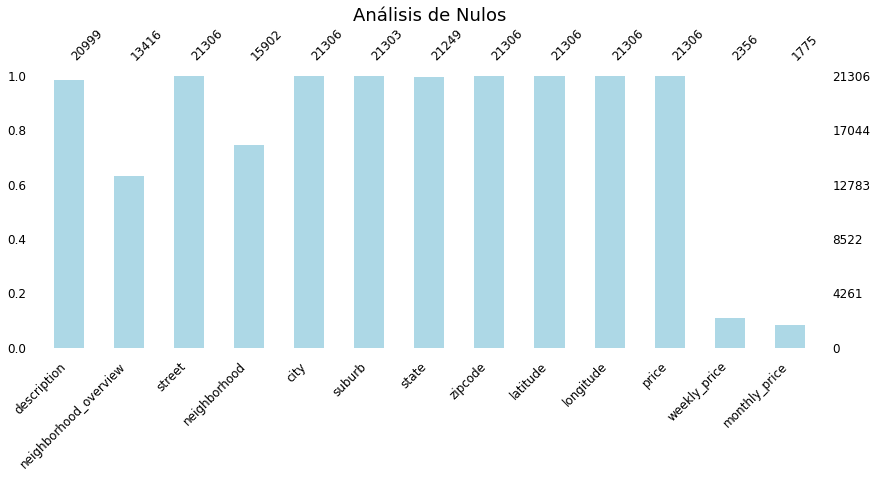

In [90]:
msno.bar(airbnb_df_2,figsize=(14, 5), fontsize=12, color='lightblue')
plt.title('Análisis de Nulos', fontsize=18)
plt.show()

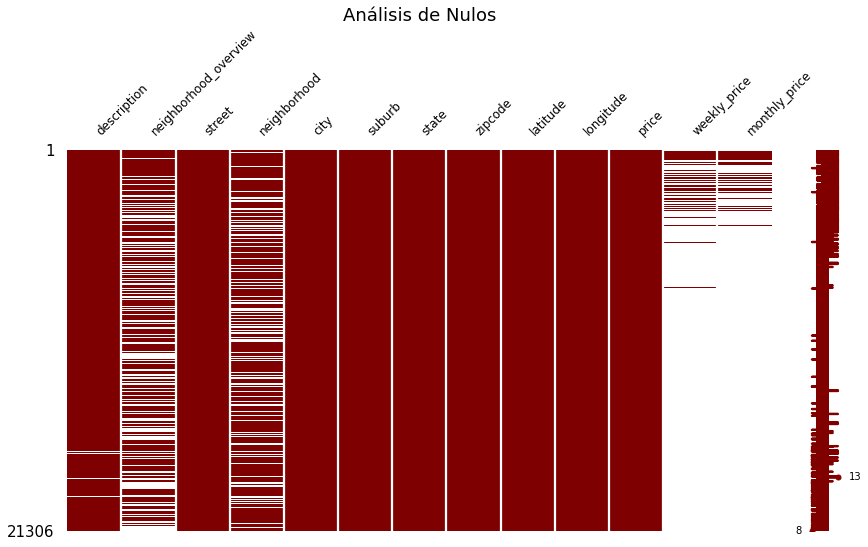

In [91]:
msno.matrix(airbnb_df_2,figsize=(14,7), fontsize=12, color=[0.5,0,0])
plt.title('Análisis de Nulos', fontsize=18)
plt.show()

Observando las columnas **weekly_price** y **monthly_price**, se puede visualizar una gran cantidad de nulos. Se descartarán ya que no aportan información al modelo actual.

Podemos ver que las columnas **neighborhood_overview** y **neighborhood**, que son las siguientes con mayor cantidad de nulos.

In [92]:
airbnb_df_2[['neighborhood_overview','neighborhood']].nunique()

neighborhood_overview    11233
neighborhood                59
dtype: int64

Se observa que:
* La columna **neighborhood** tiene 15902/21249 de datos, los cuales 59 son únicos. Se analizarán y se tomará una decisión sobre si se debe descartar.
* La columna **neighborhood_overview** tiene 13416/21249 de datos, los cuales 11233 son únicos. Se toma la decisión que es una variable 

In [93]:
airbnb_df_2.neighborhood.value_counts()

Central Business District     3529
Southbank                     1114
St Kilda                      1021
South Yarra                    976
Brunswick                      697
Carlton                        562
Docklands                      518
Richmond                       503
Fitzroy                        352
Northcote                      294
Elwood                         288
Caulfield                      284
North Melbourne                279
Collingwood                    268
Footscray                      243
South Melbourne                242
Abbotsford                     241
Prahran                        239
Hawthorn                       236
Fitzroy North                  225
Port Melbourne                 214
St Kilda East                  192
Prahran/Windsor                190
Flemington                     170
East Melbourne                 160
Brighton                       158
Preston                        156
Windsor                        155
Carnegie            

In [94]:
print('Porcentaje de filas nulas:', round((airbnb_df_2.neighborhood.isna().sum() / len(airbnb_df_2)) * 100,2))

Porcentaje de filas nulas: 25.36


La columna **neighborhood** será descartada por la cantidad de valores en nulo y no tener mucho conocimiento de dominio, ya que si hubiera manera de imputarlo y que luego nos sirviera por cada código postal, se la dejaría para enriquecer los datos.

##### Columnas posibles a descartar

Buscando en internet y comprendiendo nuestros conjuntos de datos determinamos lo siguiente:
* El país es Australia, el cual posee varios estados, y dentro, ciudades. Estamos estudiando el caso de Melbourne, del estado de Victoria.
* La ciudad que nos interesa es Melbourne y no otra, pero, vimos que Melbourne es una metrópolis. Veremos el análisis más adelante.
* La columna **suburb** es importante, ya que marca las diferentes partes o subdivisiones de Melbourne.
* El estado es Virginia, pero analizaremos el datasets para ver si se descarta.

In [95]:
airbnb_df_2[['description','street','state']]

,description,street,state
0,"House: Clean, New, Modern, Quite, Safe. 10Km f...","Bulleen, VIC, Australia",VIC
1,A large air conditioned room with queen spring...,"Brunswick East, VIC, Australia",VIC
2,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,"St Kilda, VIC, Australia",VIC
3,"Comfortable, relaxed house, a home away from ...","Thornbury, VIC, Australia",VIC
4,We offer comfortable accommodation in Inner Me...,"St Kilda East, VIC, Australia",VIC
...,...,...,...
22890,"near city, near tram station","Carlton, VIC, Australia",VIC
22891,"Close to: Melton Rail, Coles, Coffee Lounge an...","Melton South, VIC, Australia",VIC
22892,"Hi, 我是一名中国留学生. 由于暑假原因决定出租我的房间. 我会留下我所使用的物品给我的租...","Glen Waverley, VIC, Australia",VIC
22893,Immaculately presented and carefully maintaine...,"Southbank, VIC, Australia",VIC


In [96]:
airbnb_df_2[['description','street','state']].nunique()

description    20170
street           598
state             16
dtype: int64

In [97]:
airbnb_df_2['state'].value_counts()

VIC                    20382
Victoria                 796
Vic                       36
vic                       10
victoria                   5
VI                         4
维多利亚州                      3
Melbourne                  2
Australia                  2
维多利亚                       2
Victory                    2
VICTORIA                   1
VIC 3008                   1
Melbourne, Victoria        1
Mel                        1
維多利亞 VIC                   1
Name: state, dtype: int64

In [98]:
airbnb_df_2.city.value_counts()

Melbourne            6868
Port Phillip         2568
Yarra                1917
Stonnington          1497
Moreland              932
Darebin               667
Yarra Ranges          620
Boroondara            616
Whitehorse            605
Glen Eira             596
Monash                549
Maribyrnong           421
Wyndham               402
Moonee Valley         331
Bayside               300
Kingston              293
Manningham            290
Hobsons Bay           225
Banyule               196
Knox                  170
Frankston             159
Hume                  158
Greater Dandenong     145
Casey                 137
Whittlesea            136
Maroondah             114
Cardinia              113
Brimbank              106
Melton                 91
Nillumbik              84
Name: city, dtype: int64

Antes de descartar la columna **city**, observaremos la relación entre código postal y ciudad

In [99]:
airbnb_df_2[airbnb_df_2['city'] != 'Melbourne'].city.nunique()

29

In [100]:
zipcodes_mb = airbnb_df_2[airbnb_df_2['city'] == 'Melbourne'].zipcode.unique()
citys = airbnb_df_2[airbnb_df_2['city'] != 'Melbourne'].city.unique()
abnb_df_s_mb = airbnb_df_2[airbnb_df_2['city'] != 'Melbourne'][['city','zipcode']].drop_duplicates()

aux_df = pd.DataFrame()
count = 0
ci = []
zipcodes_r = []
for c in citys:
    for z in zipcodes_mb:
        if len(abnb_df_s_mb[(abnb_df_s_mb['city'] == c) & (abnb_df_s_mb['zipcode'] == z)])  > 0:
            count += 1
            ci.append(c)
            zipcodes_r.append(z)

aux_df['City'] = ci
aux_df['Zipcode'] = zipcodes_r

aux_df.sort_values(by=['City','Zipcode']).reset_index().drop(columns=['index'])

,City,Zipcode
0,Boroondara,3000
1,Boroondara,3122
2,Casey,3000
3,Glen Eira,3004
4,Maribyrnong,3004
5,Maribyrnong,3031
6,Maribyrnong,3032
7,Maribyrnong,3207
8,Moonee Valley,3004
9,Moonee Valley,3031


Buscando los códigos postales de Melbourne dentro de los códigos postales de las otras ciudades, encontramos que existen coincidencias.

Se buscaron en internet estas ciudades, y encontramos que son parte de Melbourne, por lo que quitar la columna **city** tal vez sea una equivocación. Lo que haremos, será dejarla y dejar la moda a partir del código postal.

Posibles columnas a descartar:
* La columna **description** es una variable categórica con muchos valores únicos y creemos que no nos aporta información necesaria para nuestro análisis. Se descartará.
* La columna **street** es una variable categórica con muchos valores únicos con nombre de la calle, estado y país. Estamos tratando con Melbour, una Ciudad del Estado de Victoria en Australia. Como no creemos que aporte información necesaria, decidimos descartarla.
* La columna **state** es una variable categórica con varios estados dentro del datasets. El único que priorizamos es "Victoria", por lo que no es una variable que va a cambiar y no aportará información. Se descartará.
* La columna **city** es una variable categórica que no descartaremos, y usaremos la moda como valor principal a partir del Código postal.

#### Selección de Columnas AirBnb

Resumen de selección:
* Se descartarán: 'description', 'neighborhood_overview', 'street', 'neighborhood', 'state', 'weekly_price', 'monthly_price'
* Columnas seleccionadas: 'zipcode', 'city', 'suburb', 'latitude', 'longitude', 'price'

In [101]:
relevant_columns = ['zipcode', 'city', 'suburb', 'latitude', 'longitude', 'price']

Procesos de cada columna:
* **zipcode**: Variable Categórica principal en el caso, se procederá con una agrupación.
* **city**: se tomará la moda.
* **suburb**: se tomará la moda.
* **latitude**: se tomará la media.
* **longitude**: se tomará la media.
* **price**: se tomará la media.

In [102]:
airbnb_df_final = airbnb_df_2.groupby(by=['zipcode']) \
                            .agg(airbnb_city = ('city',pd.Series.mode), 
                                 airbnb_suburb = ('suburb',pd.Series.mode), 
                                 airbnb_latitude = ('latitude','mean'), 
                                 airbnb_longitude = ('longitude','mean'), 
                                 airbnb_price = ('price','mean')).reset_index()
airbnb_df_final.airbnb_price = airbnb_df_final.airbnb_price.round(2)
airbnb_df_final

,zipcode,airbnb_city,airbnb_suburb,airbnb_latitude,airbnb_longitude,airbnb_price
0,3000,Melbourne,Melbourne,-37.813284,144.959496,130.46
1,3001,Melbourne,Melbourne,-37.808598,144.956138,132.50
2,3002,Melbourne,East Melbourne,-37.812941,144.983493,131.12
3,3003,Melbourne,West Melbourne,-37.809729,144.950095,122.83
4,3004,Melbourne,Melbourne,-37.828455,144.969290,132.06
...,...,...,...,...,...,...
229,3976,Casey,Hampton Park,-38.048198,145.265233,55.00
230,3977,Casey,Cranbourne North,-38.093543,145.273814,87.32
231,3978,Casey,Clyde North,-38.104059,145.360355,104.20
232,3980,Casey,Warneet,-38.217708,145.325937,86.40


In [103]:
airbnb_df_final.shape

(234, 6)

#### Unión de Datasets por Código Postal

Podemos observar que podemos usar el código postal para realizar una unión entre datasets.

In [104]:
intersection = np.intersect1d(
    airbnb_df_final.zipcode.values, melb_df_RC.Postcode.values, assume_unique=False)
print("Valores únicos de zipcodes en Airbnb:", len(airbnb_df_final.zipcode.unique()))
print("Valores únicos de zipcodes en melb_df_RC:", len(melb_df_RC.Postcode.unique()))
print("Códigos postales en común:", len(intersection))

Valores únicos de zipcodes en Airbnb: 234
Valores únicos de zipcodes en melb_df_RC: 198
Códigos postales en común: 191


In [106]:
print('Registros en el dataframe de Melbourne correspondiente al Código Postal del dataframe Airbnb:',
      melb_df_RC.Postcode.isin(intersection).sum() / len(melb_df_RC))
print('Registros en el dataframe de Airbnb correspondiente al Código Postal del dataframe Melbourne:',
      airbnb_df_final.zipcode.isin(intersection).sum() / len(airbnb_df_final))

Registros en el dataframe de Melbourne correspondiente al Código Postal del dataframe Airbnb: 0.9984563136770608
Registros en el dataframe de Airbnb correspondiente al Código Postal del dataframe Melbourne: 0.8162393162393162


Realizamos el Merge

In [108]:
melb_df_RC.shape

(12956, 18)

In [107]:
melb_df_exp = melb_df_RC.merge(airbnb_df_final, how='left', left_on='Postcode', right_on='zipcode').drop(columns=['zipcode'])
melb_df_exp

,Suburb,Address,Rooms,Type,Price,Date,Distance,Bathroom,Car,CouncilArea,Postcode,Lattitude,Longtitude,Landsize,BuildingArea,YearBuilt,Regionname,AgeRange,airbnb_city,airbnb_suburb,airbnb_latitude,airbnb_longitude,airbnb_price
0,Abbotsford,85 Turner St,2,h,1480000.0,2016-03-12,2.5,1.0,1.0,Yarra,3067,-37.79960,144.99840,202.0,NaN,NaN,North,S/D,Yarra,Abbotsford,-37.806220,145.001072,109.58
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,2016-04-02,2.5,1.0,0.0,Yarra,3067,-37.80790,144.99340,156.0,79.0,1900.0,North,[>70),Yarra,Abbotsford,-37.806220,145.001072,109.58
2,Abbotsford,5 Charles St,3,h,1465000.0,2017-04-03,2.5,2.0,0.0,Yarra,3067,-37.80930,144.99440,134.0,150.0,1900.0,North,[>70),Yarra,Abbotsford,-37.806220,145.001072,109.58
3,Abbotsford,40 Federation La,3,h,850000.0,2017-04-03,2.5,2.0,1.0,Yarra,3067,-37.79690,144.99690,94.0,NaN,NaN,North,S/D,Yarra,Abbotsford,-37.806220,145.001072,109.58
4,Abbotsford,55a Park St,4,h,1600000.0,2016-04-06,2.5,1.0,2.0,Yarra,3067,-37.80720,144.99410,120.0,142.0,2014.0,North,[0-5),Yarra,Abbotsford,-37.806220,145.001072,109.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12951,Westmeadows,9 Black St,3,h,582000.0,2017-08-26,16.5,2.0,2.0,NaN,3049,-37.67917,144.89390,256.0,NaN,NaN,North,S/D,Hume,Westmeadows,-37.676658,144.888622,92.29
12952,Wheelers Hill,12 Strada Cr,4,h,1245000.0,2017-08-26,16.7,2.0,2.0,NaN,3150,-37.90562,145.16761,652.0,NaN,1981.0,South,[35-40),Monash,Glen Waverley,-37.883598,145.166236,111.86
12953,Williamstown,77 Merrett Dr,3,h,1031000.0,2017-08-26,6.8,2.0,2.0,NaN,3016,-37.85927,144.87904,333.0,133.0,1995.0,West,[20-25),Hobsons Bay,Williamstown,-37.859157,144.895662,163.54
12954,Williamstown,83 Power St,3,h,1170000.0,2017-08-26,6.8,2.0,4.0,NaN,3016,-37.85274,144.88738,436.0,NaN,1997.0,West,[20-25),Hobsons Bay,Williamstown,-37.859157,144.895662,163.54


In [109]:
melb_df_exp.shape

(12956, 23)

---

---

## Ejercicio 2: Imputación

1. Imputar los valores faltantes de la columna CouncilArea en base a la información presente en Suburb. (Si en el punto anterior no seleccionó ninguna de estas variables, agréguelas ahora el conjunto de datos).




In [ ]:
melb_df_RC.CouncilArea.value_counts()

In [ ]:
melb_df_RC2=melb_df_RC.copy(deep=True)
melb_df_RC2

In [ ]:
melb_df_RC['CouncilArea'].isnull().sum(axis = 0)

In [ ]:
from sklearn_pandas import CategoricalImputer

imputer = CategoricalImputer()
melb_df_RC2['CouncilArea']=imputer.fit_transform(melb_df_RC2['CouncilArea'])


In [ ]:
melb_df_RC2['CouncilArea'].value_counts

In [ ]:
#melb_df_RC['CouncilArea']=melb_df_RC2['CouncilArea']

Tras realizar la imputación sobre el campo **CouncilArea**, podemos observar que los valores faltantes fueron reemplazados por **Moreland** que es la categoria más frecuente que se visualiza.             

2. Imputar los valores faltantes de la(s) columna(s) que se agregaron a partir del conjunto de datos de AirBnB.


In [ ]:
# Juan se me hizo lio aca para saber cuales son las columnas de AirBnB. ¿Esta en el df melb_de_RD? ¿O debo imputar sobre las columnas del df airbnb_df??

## Ejercicio 3

Crear y guardar un nuevo conjunto de datos con todas las transformaciones realizadas anteriormente.